Please run the codes in part 1 as they are the same as that in the notebook for week 10. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

from sklearn.model_selection import train_test_split

# 1. Data Preparation and Modeling

In [ ]:
# bank_data['Gender'] = bank_data['Gender'].apply(lambda x: 1 if x=='M' else 0)
# bank_data.head()

In [ ]:
churn = pd.read_csv('/content/drive/MyDrive/DATA_3105/churn.csv',sep=' ')

# convert feature COLLGE as numbers
churn.loc[churn['COLLEGE']=='zero','COLLEGE'] = 0  
churn.loc[churn['COLLEGE']=='one','COLLEGE'] = 1

# Drop 4 features for simplicity 
churn.drop(["OVER_15MINS_CALLS_PER_MONTH", "REPORTED_SATISFACTION", 
            "REPORTED_USAGE_LEVEL", "CONSIDERING_CHANGE_OF_PLAN" ], axis=1, inplace=True)

churn.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,AVERAGE_CALL_DURATION,LEAVE
1,0,31953,0,6,313378,161,4,STAY
2,1,36147,0,13,800586,244,6,STAY
3,1,27273,230,0,305049,201,15,STAY
4,0,120070,38,33,788235,780,2,LEAVE
5,1,29215,208,85,224784,241,1,STAY


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Split and Scale Data**

In [ ]:
X = churn.drop('LEAVE', axis=1)

y = churn['LEAVE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16000, 7)

(4000, 7)

(16000,)

(4000,)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)   
X_test_scaled  = scaler.transform(X_test)

Let's train three models and use their default threshold (0.5) for prediction: (1) Logistic Regression; (2) Linear SVC; (3) Decision Tree.

**Logistic Regression**

In [ ]:
lr = LogisticRegression()

lr.fit(X_train_scaled, y_train)

LogisticRegression()

**SVM**

here we use ``LinearSVC`` as ``SVC`` takes a longer training time with a large dataset.

In [ ]:
svm = LinearSVC()

svm.fit(X_train_scaled,y_train)      

#svm = SVC(kernel = 'linear', probability = True).fit(X_train,y_train)    # enable probability estimates for later use

LinearSVC()

**Decision Tree**

In [ ]:
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, min_samples_leaf = 500)      

tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=500)

# 2. Curves

First we need to estimate the class probability for the positive class (``LEAVE``) first with each model.

- Note here the probability of "LEAVE" is in the first column (index 0), STAY in the second column (index 1).

In [ ]:
lr_prob = lr.predict_proba(X_test_scaled)

lr_prob    

array([[0.67579156, 0.32420844],
       [0.67788126, 0.32211874],
       [0.28438509, 0.71561491],
       ...,
       [0.76438493, 0.23561507],
       [0.50649792, 0.49350208],
       [0.224422  , 0.775578  ]])

In [ ]:
svm_prob = svm._predict_proba_lr(X_test_scaled)   # note the _predict_proba_lr method 

svm_prob    

#svm_prob = svm.predict_proba(X_test_scaled)      
#use predict_proba() for probability estimate if use SVC() in model training 

array([[0.58255758, 0.41744242],
       [0.58359026, 0.41640974],
       [0.39655661, 0.60344339],
       ...,
       [0.63034907, 0.36965093],
       [0.5028064 , 0.4971936 ],
       [0.36338226, 0.63661774]])

In [ ]:
tree_prob = tree.predict_proba(X_test_scaled)

tree_prob       

array([[0.80815348, 0.19184652],
       [0.80815348, 0.19184652],
       [0.2232906 , 0.7767094 ],
       ...,
       [0.71056911, 0.28943089],
       [0.79759863, 0.20240137],
       [0.12683824, 0.87316176]])

## 2.1  ROC curves & Area-Under-Curve (AUC)

``sklearn`` doesn't support model visualization, therefore we can compute the metrics computed by ``sklearn`` and then visualize them using ``matplotlib``. 

**2.1(a) Functions from ``sklearn.metrics`` and ``matplotlib``**

To plot the ROC curve, we need to compute the ``true positive rate (TPR)`` and ``false positive rate (FPR)`` at different threshold (e.g., probability) with the [``roc_curve`` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) from ``sklearn.metrics`` first. 

- ``y_true``: True binary labels (*ndarray of shape (n_samples,)*). If labels are not either {-1, 1} or {0, 1}, then the ``pos_label`` should be explicitly given. 

- ``y_score``: It can either be probability estimates of the positive class, confidence values, or non-thresholded measure of decisions (*ndarray of shape (n_samples,)*)as returned by ``decision_function`` on some classifiers.  

- ``pos_label``: The label of the positive class (int or str, default= ``None``). When ``pos_label``=None, if ``y_true`` is in {-1, 1} or {0, 1}, ``pos_label`` is set to 1, otherwise an error will be raised.


In [ ]:
from sklearn.metrics import roc_curve 
 
fpr_lr, tpr_lr, thresholds = roc_curve(y_true = y_test, 
                                       y_score = lr_prob[:,0], 
                                       pos_label = 'LEAVE')    # col 1 refers to "LEAVE"

display(fpr_lr, tpr_lr, thresholds)     # thresholds:  f(x) values

array([0.        , 0.        , 0.        , ..., 0.99659367, 0.99659367,
       1.        ])

array([0.00000000e+00, 5.14138817e-04, 2.57069409e-03, ...,
       9.99485861e-01, 1.00000000e+00, 1.00000000e+00])

array([1.91913944, 0.91913944, 0.88397601, ..., 0.14437469, 0.14410168,
       0.11539524])

With the ``TPR`` and ``FPR`` computed, we can also calculate the **AUC value** with [``auc`` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html) from ``sklearn.metrics`` as well. 

In [ ]:
from sklearn.metrics import auc
 
auc_lr = auc(x = fpr_lr, y = tpr_lr)

auc_lr

0.7003971753638689

The **ROC curve** can be visualized using ``matplotlib``. 

- let's mark the AUC value accordingly.

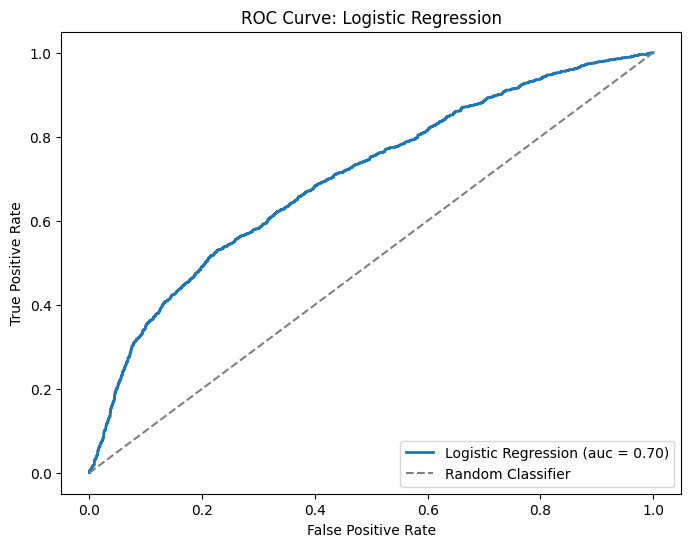

In [ ]:
plt.figure(figsize = (8, 6))
plt.plot(fpr_lr, tpr_lr, lw= 2, label='Logistic Regression (auc = {:0.2f})'.format(auc_lr))    # ROC curve
plt.plot([0, 1], [0, 1], color='grey', lw= 1.5, linestyle='--', label = 'Random Classifier')   # Diagonal Line 
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.title('ROC Curve: Logistic Regression', fontsize= 12)
plt.legend(loc='lower right', fontsize=10); 

**2.1(b) Alternatively, use the ``scikit-plot``module**

The [``plot_roc`` function](https://scikit-plot.readthedocs.io/en/stable/metrics.html) requires only the ``actual class`` and ``estimated probabilities`` for each observation.

- ``y_true`` (array-like, shape (n_samples)) – Ground truth (correct) target values.
- ``y_probas`` (array-like, shape (n_samples, n_classes)) – estimated probabilities for each class returned by a classifier.
- ``title`` (string, optional) – Title of the generated plot. Defaults to “ROC Curves”.
- ``plot_micro`` (boolean, optional) – Plot the micro average ROC curve. Defaults to True. 
- ``plot_macro`` (boolean, optional) – Plot the macro average ROC curve. Defaults to True.      
- ``classes_to_plot`` (list-like, optional) – Classes for which the ROC curve should be plotted.  If None, all classes will be plotted. ``Default`` = None.
- ``ax`` (matplotlib.axes.Axes, optional) – The axes upon which to plot the curve. If None, the plot is drawn on a new set of axes.
- ``figsize`` (2-tuple, optional) – Tuple denoting figure size of the plot e.g. (6, 6). Defaults to None.
- ``cmap`` (string or matplotlib.colors.Colormap instance, optional) – Colormap used for plotting the projection. View Matplotlib Colormap documentation for available options. https://matplotlib.org/users/colormaps.html

...

In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


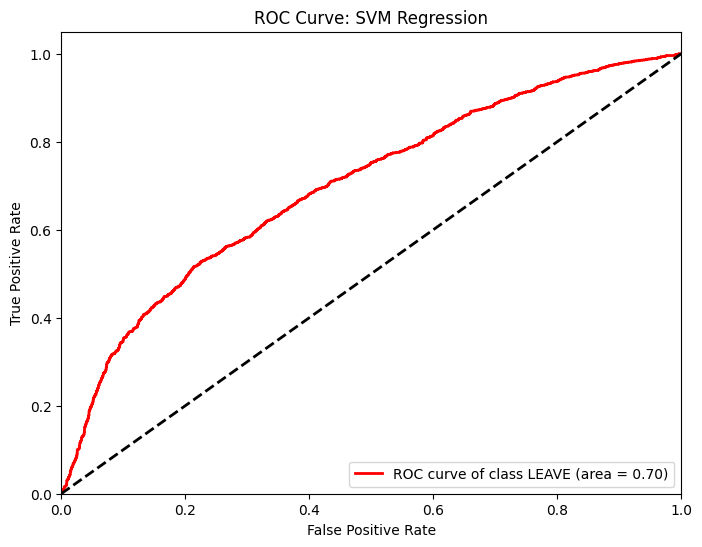

In [ ]:
from scikitplot.metrics import plot_roc

plot_roc(y_true = y_test, 
         y_probas = svm_prob,               # probability for both classes
         plot_micro = False,               # disable the micro averaging
         plot_macro = False,               # disable the macro averaging
         classes_to_plot = ['LEAVE'],      # visualize the pos class (LEAVE) only  
         title='ROC Curve: SVM Regression',
         cmap = 'autumn',
         figsize = (8, 6));

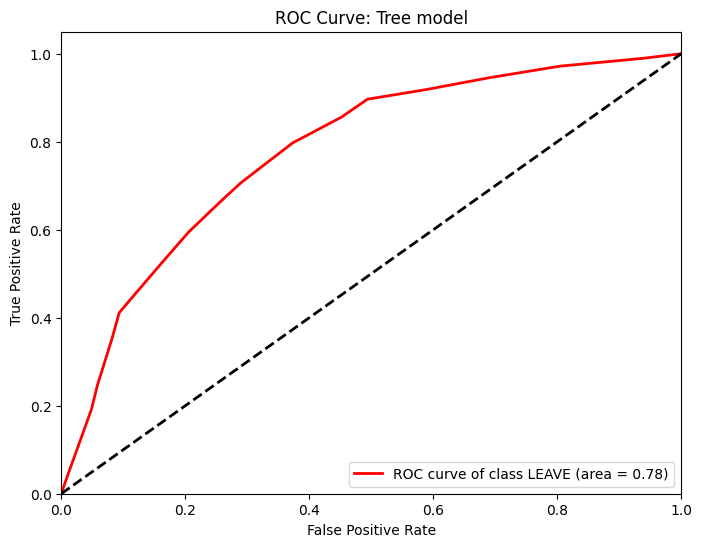

In [ ]:
plot_roc(y_true = y_test, 
         y_probas = tree_prob,               # probability for both classes
         plot_micro = False,               # disable the micro averaging
         plot_macro = False,               # disable the macro averaging
         classes_to_plot = ['LEAVE'],      # visualize the pos class (LEAVE) only  
         title='ROC Curve: Tree model',
         cmap = 'autumn',
         figsize = (8, 6));

Now, can you plot the ROC curve for both ``svm`` and ``tree`` model?

<font color=red>***Exercise 1: Your Codes Here***</font>  

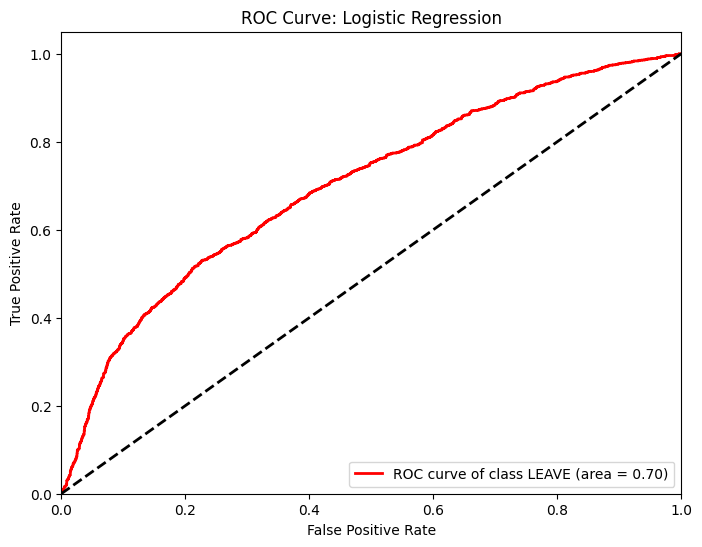

In [ ]:
plot_roc(y_true = y_test, 
         y_probas = lr_prob,               # probability for both classes
         plot_micro = False,               # disable the micro averaging
         plot_macro = False,               # disable the macro averaging
         classes_to_plot = ['LEAVE'],      # visualize the pos class (LEAVE) only  
         title='ROC Curve: Logistic Regression',
         cmap = 'autumn',
         figsize = (8, 6));

## 2.2 Cumulative Response Curves (CRC)


Check the [``plot_cumulative_gain`` function](https://scikit-plot.readthedocs.io/en/stable/metrics.html) from the ``scikitplot.metrics`` module. Both classes will be displayed.

- ``y_true``: actual values(array-like, shape (n_samples)).
- ``y_probas``: Estimated probabilities for each class returned by a classifier (array-like, shape (n_samples, n_classes)).
- ``title``: Title of the generated plot(string, optional) . ``Default`` =  “Cumulative Gains Curve”.
- ``ax``:  The axes upon which to plot the learning curve (matplotlib.axes.Axes, optional). If ``None``, the plot is drawn on a new set of axes.

...

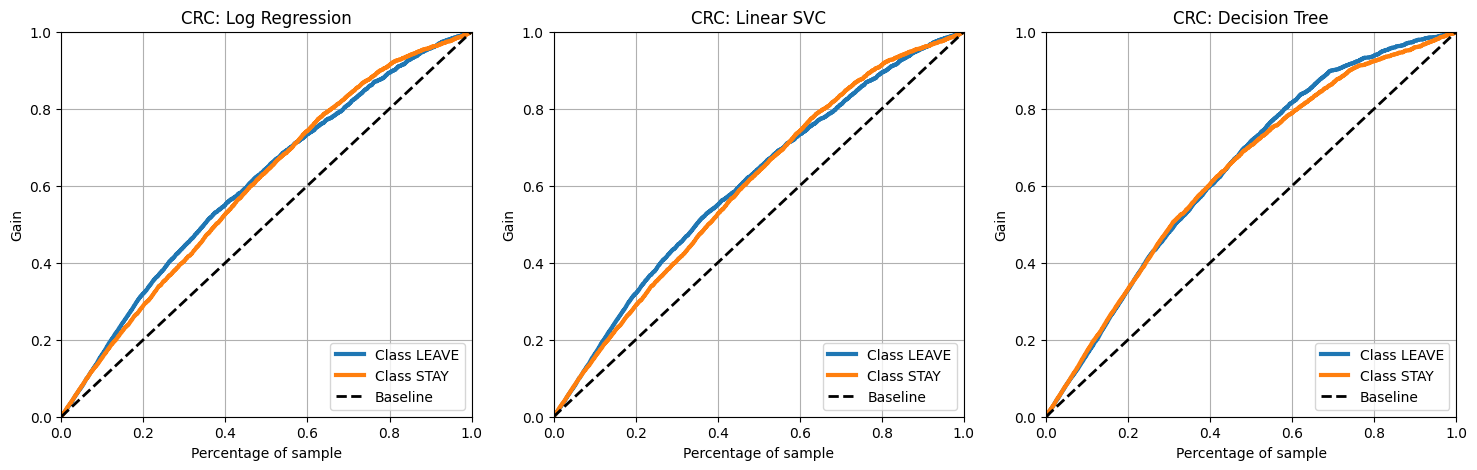

In [ ]:
from scikitplot.metrics import plot_cumulative_gain

fig, axes = plt.subplots(1,3, figsize = (18, 5))   

plot_cumulative_gain(y_test, lr_prob, ax = axes[0], title='CRC: Log Regression')
plot_cumulative_gain(y_test, svm_prob, ax = axes[1], title='CRC: Linear SVC')
plot_cumulative_gain(y_test, tree_prob, ax = axes[2], title='CRC: Decision Tree');

# Both classes are plotted by default

## 2.3 Lift Curves

Check the [``plot_lift_curve`` function](https://scikit-plot.readthedocs.io/en/stable/metrics.html) from ``scikitplot.metrics`` module. Both classes will be displayed.
 
- ``y_true`` (array-like, shape (n_samples)) – Ground truth (correct) target values.
- ``y_probas`` (array-like, shape (n_samples, n_classes)) – Prediction probabilities for each class returned by a classifier.
- ``title`` (string, optional) – Title of the generated plot. Defaults to “Lift Curve”.
- ``ax`` (matplotlib.axes.Axes, optional) – The axes upon which to plot the learning curve. If None, the plot is drawn on a new set of axes.

...

<font color=red>***Exercise 2: Your Codes Here***</font>  

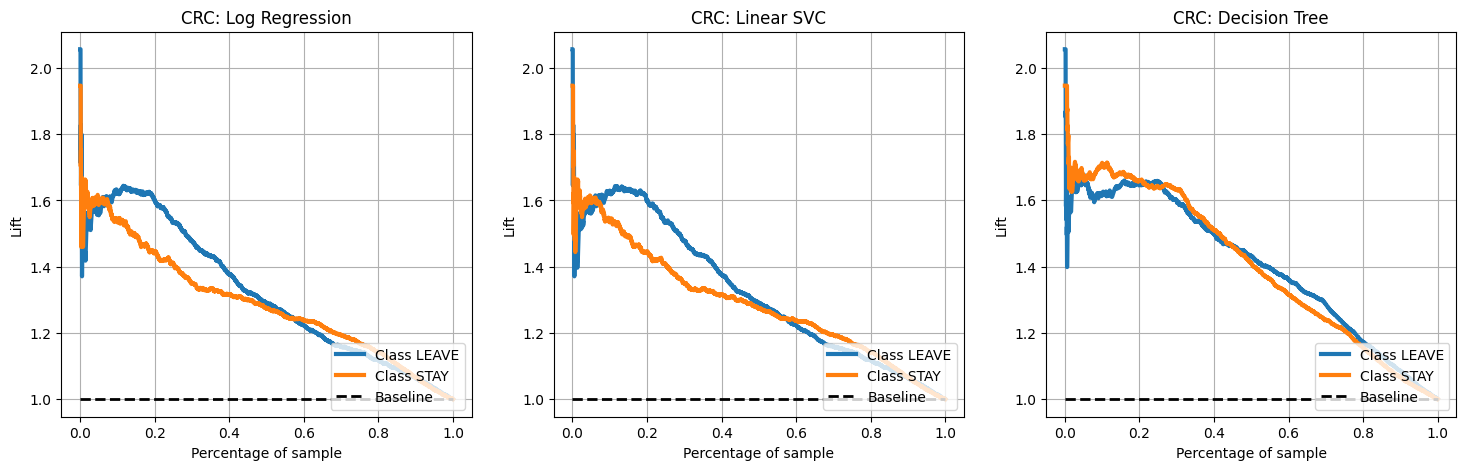

In [ ]:
from scikitplot.metrics import plot_lift_curve

fig, axes = plt.subplots(1,3, figsize = (18, 5))   

plot_lift_curve(y_test, lr_prob, ax = axes[0], title='CRC: Log Regression')
plot_lift_curve(y_test, svm_prob, ax = axes[1], title='CRC: Linear SVC')
plot_lift_curve(y_test, tree_prob, ax = axes[2], title='CRC: Decision Tree');

# Both classes are plotted by default

## 2.4 Precision Recall Curve (Optional)

The ``precision recall curve`` shows the trade-off between precision (y axis) and recall (x axis). Usually we would like to maximize both, if not possible we choose to maximize one metric that is the most important for our business goal. 

Plot the ``precision recall curve`` with the [``plot_precision_recall`` function](https://scikit-plot.readthedocs.io/en/stable/metrics.html) from ``scikitplot.metrics`` module.

- ``y_true`` (array-like, shape (n_samples)) – Ground truth (correct) target values.
- ``y_probas`` (array-like, shape (n_samples, n_classes)) – estimated probabilities for each class returned by a classifier.
- ``plot_micro`` (boolean, optional) – Plot the micro average ROC curve. Defaults to True.
- ``classes_to_plot`` (list-like, optional) – Classes for which the precision-recall curve should be plotted.  If None, all classes will be plotted. ``Default`` = None.
...

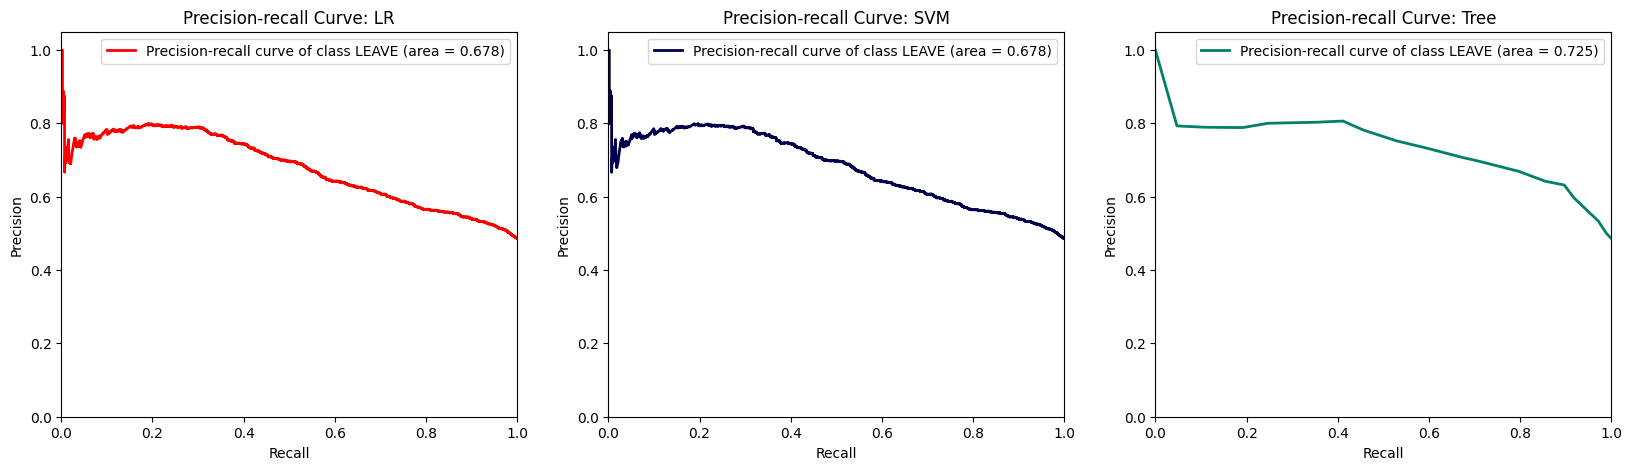

In [ ]:
from scikitplot.metrics import plot_precision_recall

fig, axes = plt.subplots(1,3, figsize = (20, 5))   

plot_precision_recall(y_true = y_test, 
                      y_probas = lr_prob, 
                      plot_micro = False,       # no micro-average ROC curve
                      classes_to_plot = ['LEAVE'],      
                      title='Precision-recall Curve: LR',
                      cmap = 'autumn',
                      ax = axes[0])

plot_precision_recall(y_true = y_test, 
                      y_probas = svm_prob, 
                      plot_micro = False,     # no micro-average ROC curve
                      classes_to_plot = ['LEAVE'],      
                      title='Precision-recall Curve: SVM',
                      cmap = 'seismic',
                      ax = axes[1])


plot_precision_recall(y_true = y_test, 
                      y_probas = tree_prob, 
                      plot_micro = False,     # no micro-average ROC curve
                      classes_to_plot = ['LEAVE'],      
                      title='Precision-recall Curve: Tree',
                      cmap = 'summer',
                      ax = axes[2]);

Alternatively, use the [``precision_recall_curve`` frunction](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) from the ``sklearn.metrics`` module to compute the ``recall`` and ``precision`` scores at different thresholds, then visualize them as a line.